# ResNetFCN on VOC2012

## Import modules

In [1]:
import os 
import glob as glob
import pathlib

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers

from PIL import Image , ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Declare data generators

In [2]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

N_CLASSES = 21

In [3]:
def parse_record(record):
    name_to_features = {
        'rows': tf.io.FixedLenFeature([], tf.int64),
        'cols': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

def decode_record(record):
    image = tf.io.decode_raw(
        record['image'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
    target = tf.io.decode_raw(
        record['target'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
        
    rows = record['rows']
    cols = record['cols']
    depth = record['depth']

    image = tf.reshape(image, (rows,cols,depth))
    target = tf.reshape(target, (rows,cols))
    
    return (image,target)

In [4]:
AUTO = tf.data.experimental.AUTOTUNE 

def read_tf_image_and_label(record):    
    parsed_record = parse_record(record)
    X, y = decode_record(parsed_record)
    X = tf.cast(X, tf.float32) / 255.0
    return X, y

def get_training_dataset(record_files):
    dataset = tf.data.TFRecordDataset(record_files, buffer_size=100)
    dataset = dataset.map(read_tf_image_and_label, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO) 
    return dataset

## Declare model

In [5]:
class ResNetFCN(tf.keras.Model):
    """FCN for VOC2012 with ResNet for Transfer Learning."""
    def __init__(self,input_shape=(320, 224, 3), **kwargs):
        super(ResNetFCN, self).__init__(**kwargs)
        self.model = self.getModel(input_shape)

    def getModel(self,input_shape):
        # Load weights pre-trained on ImageNet.
        base_model = tf.keras.applications.ResNet101V2(
        weights="imagenet",  
                input_shape=input_shape,
                include_top=False,
        )

        # Make first 400 layers non-trainable
        i = 0
        for layer in base_model.layers:
            if i < 400:
                layer.trainable = False
            i += 1
        feat_ex = tf.keras.Model(base_model.input,base_model.layers[-10].output)

        # Build FCN
        inputs = tf.keras.Input(input_shape)
        x = feat_ex(inputs)
        x = layers.UpSampling2D(2)(x)
        for filters in [500, 400, 300, 200]:
            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 4,kernel_regularizer= regularizers.l2(0.01), padding="same")(x)
            x = layers.LayerNormalization()(x)
            x = layers.Dropout(.3)(x)

            x = layers.Activation("relu")(x)
            x = layers.Conv2DTranspose(filters, 4,kernel_regularizer= regularizers.l2(0.01), padding="same")(x)
            x = layers.LayerNormalization()(x)
            x = layers.Dropout(.3)(x)

            x = layers.UpSampling2D(2)(x)

        output = layers.Conv2D(N_CLASSES, 1,kernel_regularizer= regularizers.l2(0.001),activation="softmax",padding="same")(x)
        model = tf.keras.Model(inputs,output)

        print(model.summary())
        return model

    def train_step(self, data):
        X, y = data[0], data[1]
        with tf.GradientTape() as tape:
            yh = self.model(X)
            total_loss = self.compiled_loss(y,yh)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(y, yh)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        X, y = data[0], data[1]
        yh = self.model(X)
        total_loss = self.compiled_loss(y,yh)
        self.compiled_metrics.update_state(y, yh)
        return {m.name: m.result() for m in self.metrics}

    def call(self, X):
        yh = self.model(X)
        return yh

## Train model

In [ ]:
train_dataset = get_training_dataset("tfData/train_record.tfrecords")
train_dataset = train_dataset.shuffle(10000).batch(64)

valid_dataset = get_training_dataset("tfData/val_record.tfrecords")
valid_dataset = valid_dataset.shuffle(10000).batch(64)

In [ ]:
model = ResNetFCN()
opt = tf.keras.optimizers.Nadam(learning_rate = 0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="ResNetFCN_VOC2012.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 30
model.fit(train_dataset,epochs=epochs,validation_data=valid_dataset,
          callbacks=model_checkpoint_callback)

model.save_weights("final_weights.h5")

## Make tf lite model

In [ ]:
model = ResNetFCN()
model.load_weights("ResNetFCN_VOC2012.h5")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model.model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_models_dir = pathlib.Path("f16_lite_model")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/'ResNetFCN_VOC2012_f16.tflite'
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

## Test tf lite model

In [6]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="f16_lite_model/ResNetFCN_VOC2012_f16.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [7]:
dataset = tf.data.TFRecordDataset('tfData/val_record.tfrecords', buffer_size=10)

In [8]:
images, labels = [], []
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    img, label = decoded_record
    images.append(img)
    labels.append(label)

In [9]:
sample_number = 5

sample_img = images[sample_number].numpy()/255.0
sample_img = sample_img.reshape(1,320,224,3)
sample_img_tensor = tf.convert_to_tensor(sample_img, dtype='float32')

interpreter.set_tensor(input_details[0]['index'], sample_img_tensor)
interpreter.invoke()
yh = interpreter.get_tensor(output_details[0]['index'])

yh = yh*255.0
yh = yh.astype('int')
yh = np.argmax(yh[0,:,:,:],axis=-1)

Classes found: ['background', 'cat', 'cow', 'dog', 'sheep']


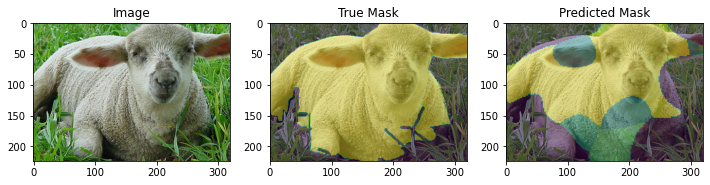

In [10]:
# Plot image, mask, and predicted mask
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i == 1:
        img = images[sample_number].numpy()
        img = Image.fromarray(img,'RGB')
        plt.imshow(np.transpose(np.array(img), (1,0,2)))
        plt.title('Image') 
    elif i == 2:
        outline = labels[sample_number].numpy()
        outline = Image.fromarray(outline)
        plt.imshow(np.transpose(np.array(img), (1,0,2)))
        plt.imshow(np.transpose(np.array(outline), (1,0)),alpha=.4)
        plt.title("True Mask")
    elif i == 3:
        plt.imshow(np.transpose(np.array(img), (1,0,2)))
        plt.imshow(np.transpose(yh, (1,0)), alpha=0.4)
        plt.title("Predicted Mask")
        
# Check predicted unique classes
yh_unique = np.unique(yh)
classes_found = []
for c in yh_unique.tolist():
    classes_found.append(VOC_CLASSES[c])
print("Classes found: {}".format(classes_found))

### Custom pic test

(224, 320, 3)


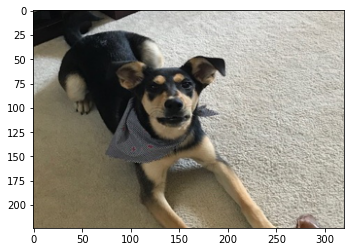

In [11]:
test_pic = Image.open("test_pic.jpg")
test_pic = test_pic.resize((320,224)) 
test_pic = np.array(test_pic)
plt.imshow(test_pic)
print(test_pic.shape)

In [12]:
test_pic = np.transpose(test_pic, (1,0,2))
test_pic = test_pic.reshape(1,320,224,3)
test_pic = test_pic/255.0
test_pic_tensor = tf.convert_to_tensor(test_pic, dtype='float32')

interpreter.set_tensor(input_details[0]['index'], test_pic_tensor)
interpreter.invoke()
yh = interpreter.get_tensor(output_details[0]['index'])

yh = yh*255.0
yh = yh.astype('int')
yh = np.argmax(yh[0,:,:,:],axis=-1)

Classes found: ['background', 'dog', 'person']


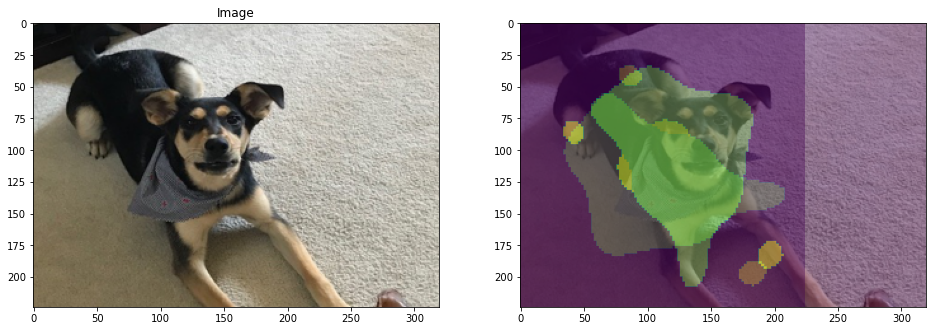

In [13]:
# Plot image, mask, and predicted mask
test_pic = Image.open("test_pic.jpg")
test_pic = test_pic.resize((320,224)) 
test_pic = np.array(test_pic)

fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i == 1:
        img = test_pic
        img = Image.fromarray(img,'RGB')
        plt.imshow(np.array(img))
        plt.title('Image')
    elif i == 2:
        plt.imshow(test_pic)
        plt.imshow(yh, alpha=0.4)
        plt.imshow(np.transpose(yh, (1,0)), alpha=0.4)
        
# Check predicted unique classes
yh_unique = np.unique(yh)
classes_found = []
for c in yh_unique.tolist():
    classes_found.append(VOC_CLASSES[c])
print("Classes found: {}".format(classes_found))